In [5]:
import os
data_dir = 'C:/Users/pongsasit/Desktop/code/jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

In [6]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
#if we use pandas
import pandas as pd
data = pd.read_csv('C:/Users/pongsasit/Desktop/code/jena_climate/jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
#parsing the data
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

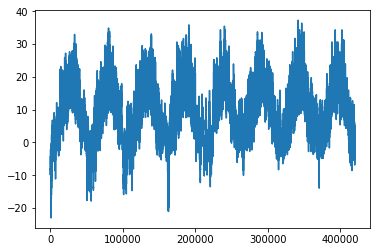

In [11]:
from matplotlib import pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)), temp)


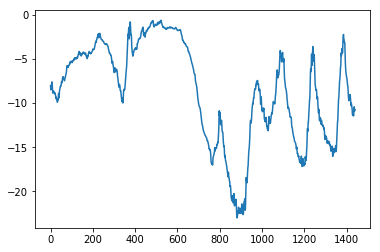

In [15]:
#data recorded every 10minute
#144 data points per day
#first 10 days = 1440 points
plt.plot(range(1440), temp[:1440])

In [17]:
#preparing data
#lookback = 720 - Observations will go back 5 days
#steps = 6 Observations will be sampled at one data point per hour
#delay = 144 Target will be 24 hours in the future
#normalizing data

mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

In [18]:
def generator(data_1, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+ batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback//step,
                           data_1.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data_1[indices]
            targets[j] = data_1[rows[j] + delay][1]
        yield samples, targets

In [19]:
#data_1 = original array
#lookback = how many timestep that we want to look back
#delay = how many timesteps in the future the target should be
#min_index max_index indice the data_1 array 
#shuffle draw data in chronological order
#batch_size = the number of samples per batch
#step= period

In [20]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [24]:
#train, validation, test
train_gen = generator(float_data,lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size= batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index = 300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=300001,
                   max_index = None,
                   step=step,
                   batch_size=batch_size)

val_steps = (300000-200001-lookback) // batch_size
test_steps =(len(float_data)-300001-lookback)//batch_size

In [25]:
#baseline MAE

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


In [ ]:
#evaluate_generator = we check the loss not accuracy

In [26]:
#convert the MAE back to Celsius error

In [38]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [30]:
#easy model densely connected model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback// step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data = val_gen,
                             validation_steps=val_steps)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 17s 35ms/step - loss: 1.6059 - val_loss: 0.7457
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.5975 - val_loss: 0.3509
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3334 - val_loss: 0.3107
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2788 - val_loss: 0.3089
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2620 - val_loss: 0.2968
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2502 - val_loss: 0.3008 - loss: 0.25
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2430 - val_loss: 0.3144
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2381 - val_loss: 0.3361
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2326 - val_loss: 0.3336
Epoch 10/20
500/500 [

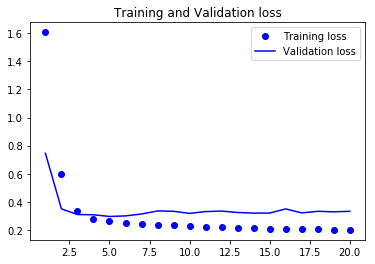

In [31]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [42]:
model.evaluate_generator(test_gen,steps=test_steps)

1.3470850026335126

In [33]:
#use GRU instead of easy Neural Network
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_gru = Sequential()
model_gru.add(layers.GRU(32,input_shape = (None, float_data.shape[-1])))
model_gru.add(layers.Dense(1))

model_gru.compile(optimizer=RMSprop(), loss='mae')

history = model_gru.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data = val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 140s 280ms/step - loss: 0.3110 - val_loss: 0.2733
Epoch 2/20
500/500 [==============================] - 139s 279ms/step - loss: 0.2853 - val_loss: 0.2696
Epoch 3/20
500/500 [==============================] - 139s 279ms/step - loss: 0.2777 - val_loss: 0.2657
Epoch 4/20
500/500 [==============================] - 139s 277ms/step - loss: 0.2744 - val_loss: 0.2685
Epoch 5/20
500/500 [==============================] - 138s 276ms/step - loss: 0.2683 - val_loss: 0.2664
Epoch 6/20
500/500 [==============================] - 138s 276ms/step - loss: 0.2647 - val_loss: 0.2702
Epoch 7/20
500/500 [==============================] - 138s 277ms/step - loss: 0.2601 - val_loss: 0.2757
Epoch 8/20
500/500 [==============================] - 138s 277ms/step - loss: 0.2561 - val_loss: 0.2775
Epoch 9/20
500/500 [==============================] - 139s 277ms/step - loss: 0.2526 - val_loss: 0.2740
Epoch 10/20
500/500 [==============================] - 140s 279m

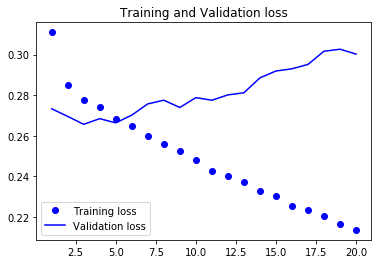

In [34]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

#new Val mae is around 0.65 around 2.35degC

In [43]:
model_gru.evaluate_generator(test_gen,steps=test_steps)

0.31408840906155366

In [36]:
#to fight overfitting
#training and evaluating a dropout-regularized GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_do = Sequential()
model_do.add(layers.GRU(32,
                    dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model_do.add(layers.Dense(1))
model_do.compile(optimizer=RMSprop(),loss='mae')

history_do = model_do.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)


Epoch 1/40
500/500 [==============================] - 151s 302ms/step - loss: 0.3329 - val_loss: 0.2759
Epoch 2/40
500/500 [==============================] - 148s 297ms/step - loss: 0.3151 - val_loss: 0.2745
Epoch 3/40
500/500 [==============================] - 149s 297ms/step - loss: 0.3107 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 148s 297ms/step - loss: 0.3068 - val_loss: 0.2713
Epoch 5/40
500/500 [==============================] - 148s 297ms/step - loss: 0.3029 - val_loss: 0.2700
Epoch 6/40
500/500 [==============================] - 149s 297ms/step - loss: 0.2995 - val_loss: 0.2688
Epoch 7/40
500/500 [==============================] - 148s 297ms/step - loss: 0.2978 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 149s 297ms/step - loss: 0.2977 - val_loss: 0.2656
Epoch 9/40
500/500 [==============================] - 149s 297ms/step - loss: 0.2942 - val_loss: 0.2656
Epoch 10/40
500/500 [==============================] - 149s 298m

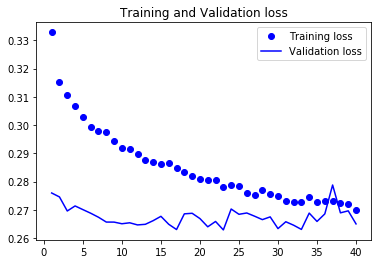

In [37]:
import matplotlib.pyplot as plt
loss = history_do.history['loss']
val_loss = history_do.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [44]:
model_do.evaluate_generator(test_gen,steps=test_steps)

0.27891711671586317

In [48]:
#increase capacity of the network
#Recurrent layer stacking
#all intermediate layers return their full sequence of outputs
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_rls = Sequential()
model_rls.add(layers.GRU(32,
                       dropout=0.1,
                       recurrent_dropout=0.5,
                       return_sequences=True,
                       input_shape=(None, float_data.shape[-1])))
model_rls.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
model_rls.add(layers.Dense(1))

model_rls.compile(optimizer=RMSprop(),loss='mae')
history_rls=model_rls.fit_generator(train_gen,
                                   steps_per_epoch=500,
                                   epochs=40,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)


Epoch 1/40
500/500 [==============================] - 333s 666ms/step - loss: 0.3151 - val_loss: 0.2731
Epoch 3/40
500/500 [==============================] - 335s 669ms/step - loss: 0.3072 - val_loss: 0.2796
Epoch 4/40
500/500 [==============================] - 335s 669ms/step - loss: 0.3013 - val_loss: 0.2674
Epoch 5/40
500/500 [==============================] - 343s 685ms/step - loss: 0.2966 - val_loss: 0.2682
Epoch 7/40
500/500 [==============================] - 345s 690ms/step - loss: 0.2931 - val_loss: 0.2647
Epoch 8/40
500/500 [==============================] - 339s 677ms/step - loss: 0.2906 - val_loss: 0.2660
Epoch 9/40
500/500 [==============================] - 334s 668ms/step - loss: 0.2876 - val_loss: 0.2606
Epoch 10/40
500/500 [==============================] - 334s 667ms/step - loss: 0.2851 - val_loss: 0.2610
Epoch 11/40
500/500 [==============================] - 334s 668ms/step - loss: 0.2803 - val_loss: 0.2682
Epoch 12/40
500/500 [==============================] - 334s 66

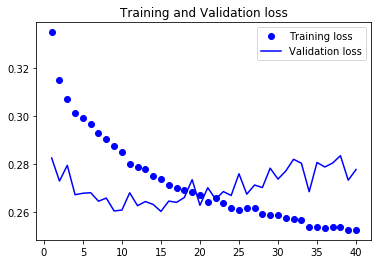

In [50]:
import matplotlib.pyplot as plt
loss = history_rls.history['loss']
val_loss = history_rls.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [51]:
model_rls.evaluate_generator(test_gen,steps=test_steps)

0.2879747460405993

In [52]:
#bidirectional rNN with GRU
def generator(data_1, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+ batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback//step,
                           data_1.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data_1[indices]
            targets[j] = data_1[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

        

In [57]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_ro = Sequential()
model_ro.add(layers.GRU(32,
                       dropout=0.1,
                       recurrent_dropout=0.5,
                       return_sequences=True,
                       input_shape=(None, float_data.shape[-1])))
model_ro.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
model_ro.add(layers.Dense(1))

model_ro.compile(optimizer=RMSprop(),loss='mae')
history_ro=model_ro.fit_generator(train_gen,
                                   steps_per_epoch=500,
                                   epochs=40,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)


Epoch 1/40
500/500 [==============================] - 337s 675ms/step - loss: 0.3326 - val_loss: 0.2768
Epoch 2/40
500/500 [==============================] - 333s 666ms/step - loss: 0.3114 - val_loss: 0.2758
Epoch 3/40
500/500 [==============================] - 335s 670ms/step - loss: 0.3067 - val_loss: 0.2747
Epoch 4/40
500/500 [==============================] - 334s 669ms/step - loss: 0.3022 - val_loss: 0.2723
Epoch 5/40
500/500 [==============================] - 334s 669ms/step - loss: 0.2989 - val_loss: 0.2724
Epoch 6/40
500/500 [==============================] - 337s 673ms/step - loss: 0.2957 - val_loss: 0.2669
Epoch 7/40
500/500 [==============================] - 334s 668ms/step - loss: 0.2929 - val_loss: 0.2644
Epoch 8/40
500/500 [==============================] - 336s 671ms/step - loss: 0.2878 - val_loss: 0.2625
Epoch 9/40
500/500 [==============================] - 334s 667ms/step - loss: 0.2849 - val_loss: 0.2647
Epoch 10/40
500/500 [==============================] - 330s 660m

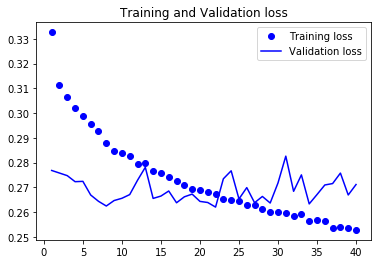

In [58]:
import matplotlib.pyplot as plt
loss = history_ro.history['loss']
val_loss = history_ro.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [59]:
#reversed order GRU 
model_ro.evaluate_generator(test_gen,steps=test_steps)

0.28439216124274397

In [60]:
#bidirectional GRU
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_bidirec = Sequential()
model_bidirec.add(layers.Bidirectional(layers.GRU(32),input_shape=(None, float_data.shape[-1])))
model_bidirec.add(layers.Dense(1))

model_bidirec.compile(optimizer=RMSprop(),loss='mae')
history_bidirec=model_bidirec.fit_generator(train_gen,
                                   steps_per_epoch=500,
                                   epochs=40,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 183s 365ms/step - loss: 0.2933 - val_loss: 0.2738
Epoch 2/40
500/500 [==============================] - 179s 359ms/step - loss: 0.2734 - val_loss: 0.2655
Epoch 3/40
500/500 [==============================] - 179s 358ms/step - loss: 0.2694 - val_loss: 0.2628
Epoch 4/40
500/500 [==============================] - 179s 358ms/step - loss: 0.2630 - val_loss: 0.2672
Epoch 5/40
500/500 [==============================] - 180s 359ms/step - loss: 0.2554 - val_loss: 0.2661
Epoch 6/40
500/500 [==============================] - 179s 359ms/step - loss: 0.2505 - val_loss: 0.2707
Epoch 7/40
500/500 [==============================] - 179s 358ms/step - loss: 0.2433 - val_loss: 0.2704
Epoch 8/40
500/500 [==============================] - 179s 358ms/step - loss: 0.2375 - val_loss: 0.2763
Epoch 9/40
500/500 [==============================] - 179s 359ms/step - loss: 0.2334 - val_loss: 0.2869
Epoch 10/40
500/500 [==============================] - 180s 359m

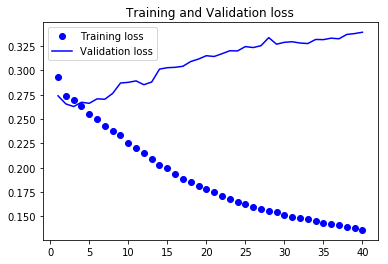

In [61]:
import matplotlib.pyplot as plt
loss = history_bidirec.history['loss']
val_loss = history_bidirec.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [62]:
#bidirectional GRU
model_bidirec.evaluate_generator(test_gen,steps=test_steps)

0.3305623996401987